In [76]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [77]:
def benchmark(X, Y):
    return -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np. pi * Y))) + np.exp(1))


In [78]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [79]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [80]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-35, 35, 5)
Y = np.random.uniform(-35, 35, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [81]:
df

x          y          z
0  -5.808460 -28.536298 -21.648132
1  15.422715 -21.961785 -21.250438
2 -34.991994 -10.810749 -20.641314
3 -13.836720  -7.226277 -19.245342
4 -24.727088   2.717171 -21.194934

In [82]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [83]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 7.59309092 -3.05536364]


In [84]:
df_sim = df.copy()

df_sim

x          y          z         a         b      sim_z       diff
0  -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1  15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2 -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3 -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4 -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522

In [85]:
df

x          y          z         a         b      sim_z       diff
0  -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1  15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2 -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3 -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4 -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522

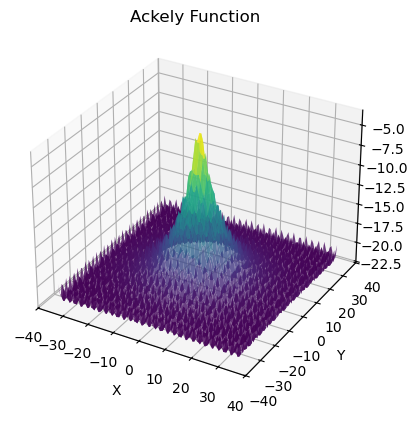

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-35, 35, 100)
y_range = np.linspace(-35, 35, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ackely Function')

# Show the plot
plt.show()

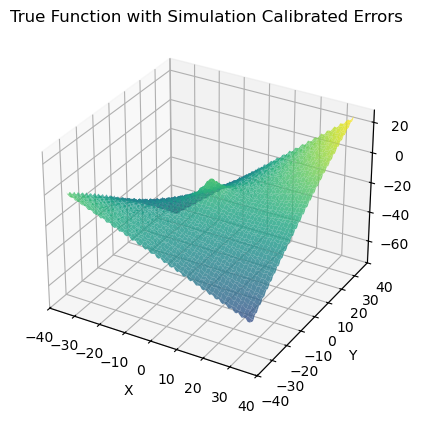

In [87]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [88]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [89]:
df_new = pd.DataFrame

In [90]:
obj_val_df = pd.DataFrame(columns=["Highest_Sim_Response", "Num_Points_In_df"])

In [91]:
round_val_df = pd.DataFrame(columns=["Highest_phy_Response", "Round_num"])

new_entry1 = pd.DataFrame({"Highest_phy_Response": [df['z'].max()],
                          "Round_num": [0]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [92]:
def perform_iteration(df, df2):
    # # Define the objective function to minimize
    # @use_named_args(hyp_space)
    # def objective(**params):
    #     num_layers = params['num_layers']
    #     num_units = params['num_units']
    #     learning_rate = params['learning_rate']
    #     dropout_rate = params['dropout_rate']
    #     batch_size = params['batch_size']
    #     epochs = params['epochs']

    #     model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    #     # Define K-fold cross-validation
    #     kfold = KFold(n_splits=3, shuffle=True, random_state=0)
    #     scores = []

    #     # Perform cross-validation
    #     for train_idx, val_idx in kfold.split(df[['x', 'y']]):
    #         X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
    #         y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

    #         # Standardize the features
    #         scaler_x = StandardScaler().fit(X_train)
    #         X_train_scaled = scaler_x.transform(X_train)
    #         X_val_scaled = scaler_x.transform(X_val)

    #         # Train the model
    #         model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

    #         # Evaluate the model
    #         score = model.evaluate(X_val_scaled, y_val, verbose=0)
    #         scores.append(score)
    
    #     return np.mean(scores)

    # # Perform Bayesian optimization
    # result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    # print("Best hyperparameters:")
    # print("num_layers:", result.x[0])
    # print("num_units:", result.x[1])
    # print("learning_rate:", result.x[2])
    # print("dropout_rate:", result.x[3])
    # print("batch_size:", result.x[4])
    # print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=5,
        num_units=150,
        learning_rate=0.01,
        dropout_rate=0.2
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=200, batch_size=128, verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-35, 35, 100)
    x2_range = np.linspace(-35, 35, 100)
    bounds = np.array([[-35, 35], [-35, 35]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    global obj_val_df
    # Append to tracking DataFrame
    new_entry = pd.DataFrame({
        "Highest_Sim_Response": [df2['sim_z'].max()],
        "Num_Points_In_df": [len(df)]
    })
    obj_val_df = pd.concat([obj_val_df, new_entry], ignore_index=True)

    return df, df2


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 627.9621
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 615.7753
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 583.8829
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 483.8976
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 378.5480
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 369.7374
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 262.2625
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 170.7729
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 68.4943
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 67.2700
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 46.1960
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 41.9768
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 351.5648
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 62.6384
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 50.48

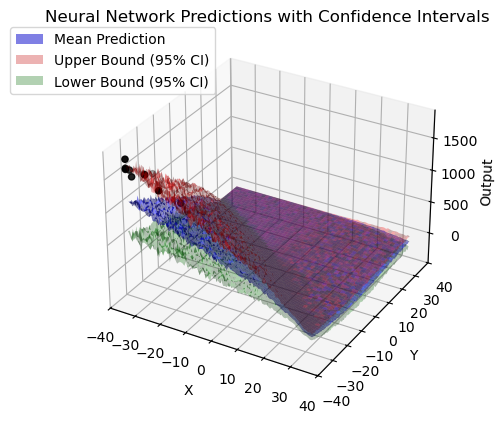

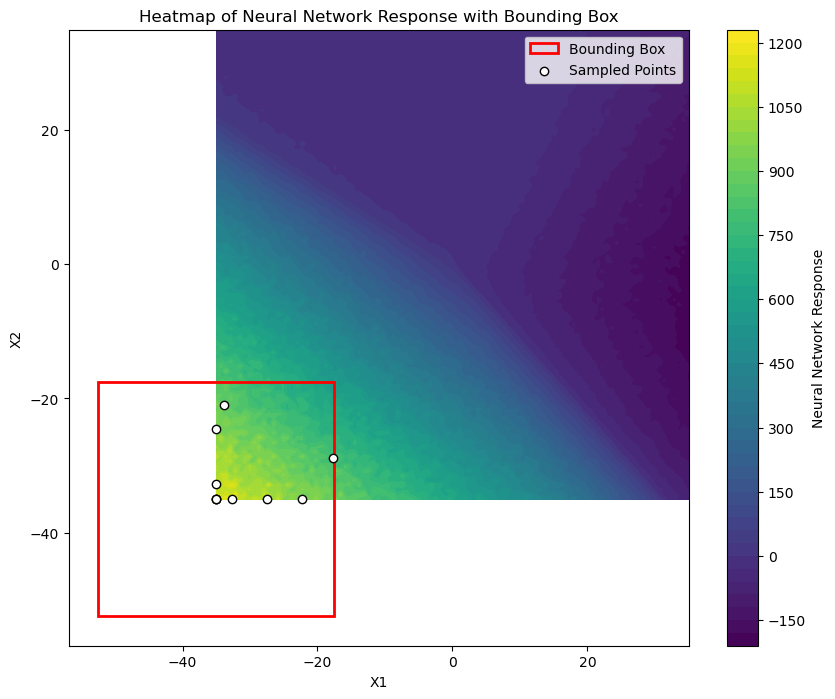

           x          y          z         a         b     sim_z       diff
2 -35.000000 -35.000000 -20.087854  7.593091 -3.055364  0.807605 -20.895459
3 -35.000000 -35.000000 -19.944158  7.593091 -3.055364  0.807605 -20.751764
9 -35.000000 -35.000000 -20.031829  7.593091 -3.055364  0.807605 -20.839434
0 -32.678598 -35.000000 -21.408322  7.593091 -3.055364 -2.182094 -19.226228
6 -35.000000 -32.721311 -21.140686  7.593091 -3.055364 -2.364186 -18.776500
            x          y          z         a         b      sim_z       diff
0   -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1   15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2  -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3  -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4  -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522
5  -32.678598 -35.000000 -21.408322  7.593091 -3.055364  -2.182094 -19.22622

In [93]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 253.1678
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 253.4231
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 251.7214
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 248.1036
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 250.7079
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 241.9803
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 235.6053
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 224.8150
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 245.1435
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 230.7751
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 231.3845
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 213.1930
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 200.9722
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 199.1973
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 

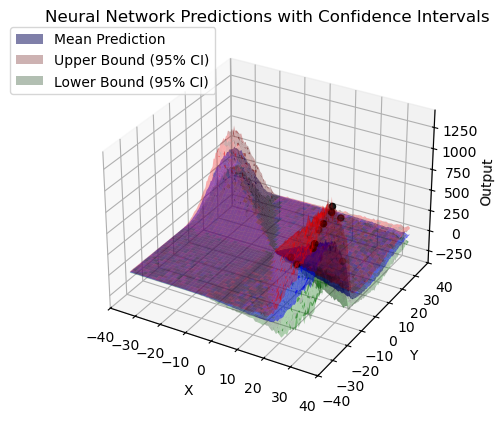

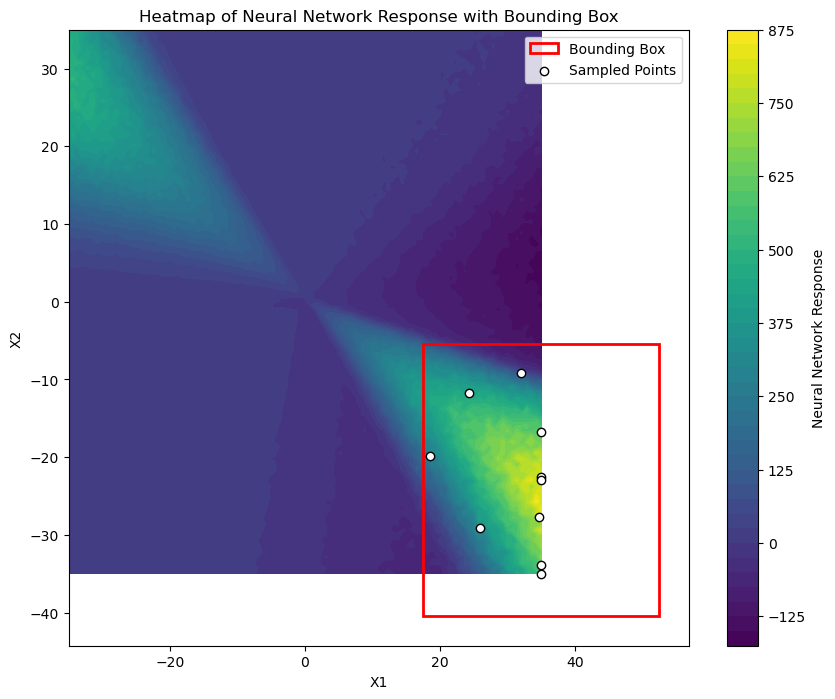

In [94]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 628.0036
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 593.2166
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 499.0153
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 280.3413
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 561.1608
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 217.6609
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 282.1159
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 345.3916
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 356.1942
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 348.1603
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 284.3547
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 232.6013
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 159.7129
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 242.6427
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 

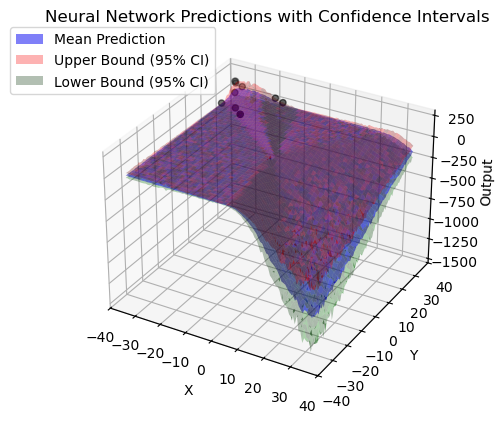

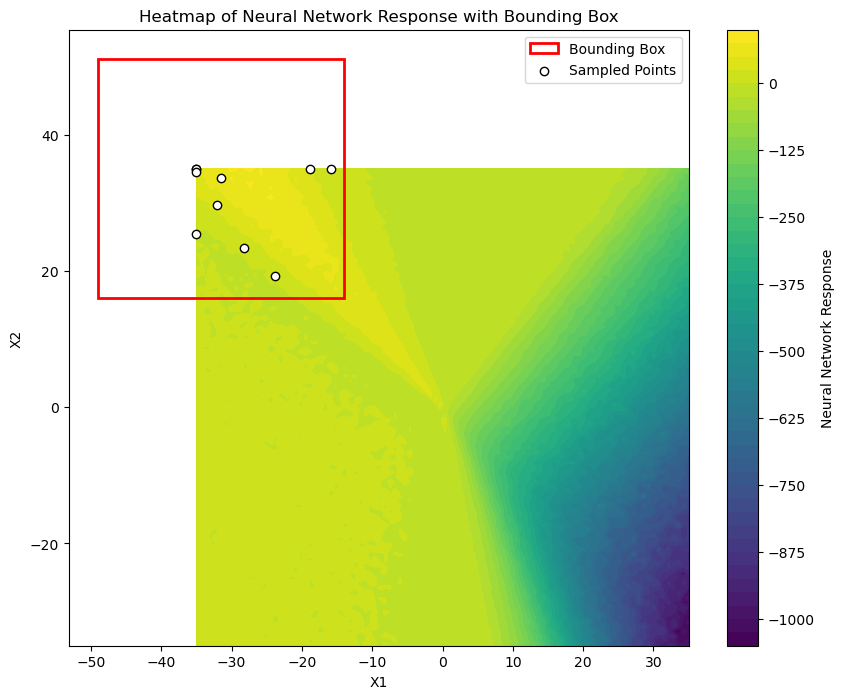

In [95]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1537.3579
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1386.1879
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 888.7782
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 481.1194
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 472.4396
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 289.1884
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 415.3204
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 404.1380
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 293.0619
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 310.3264
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 510.2488
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 246.1927
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 217.5420
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 261.3940
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss

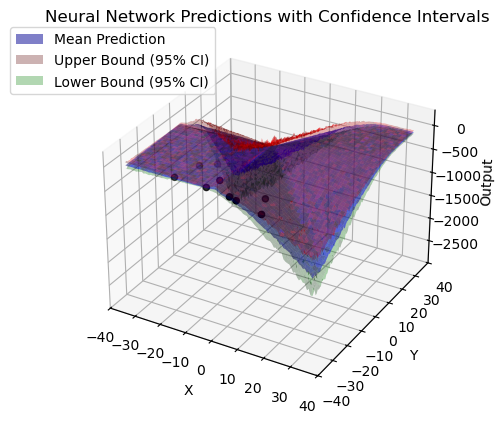

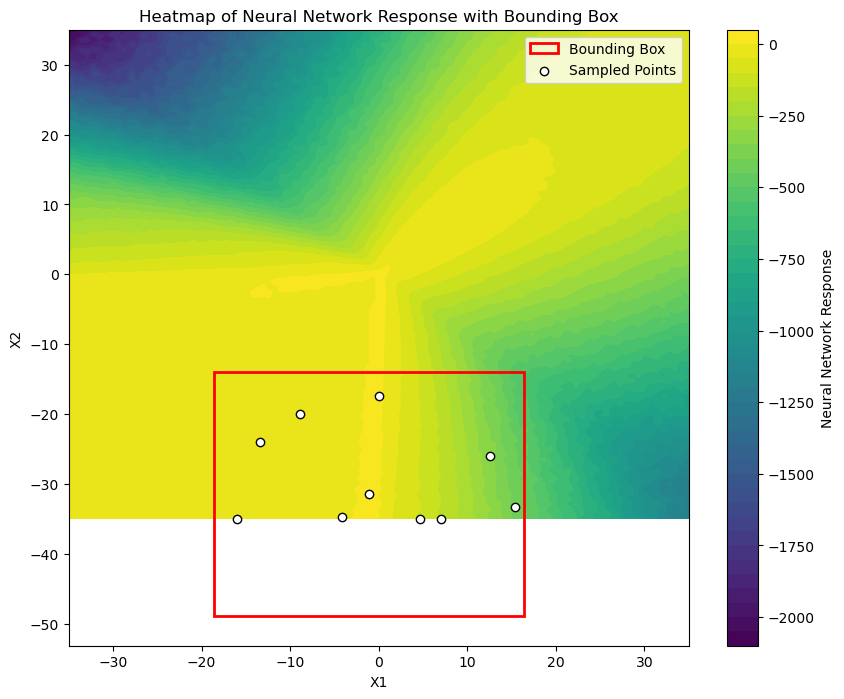

In [96]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1330.1775
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1240.2960
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 886.7260
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 377.6944
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 806.9299
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 291.1849
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 493.2189
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 598.5510
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 644.1556
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 470.5087
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 314.5569
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 222.6689
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 360.4734
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 548.4695
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss

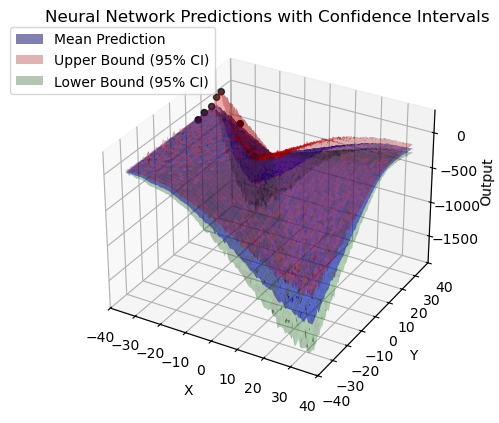

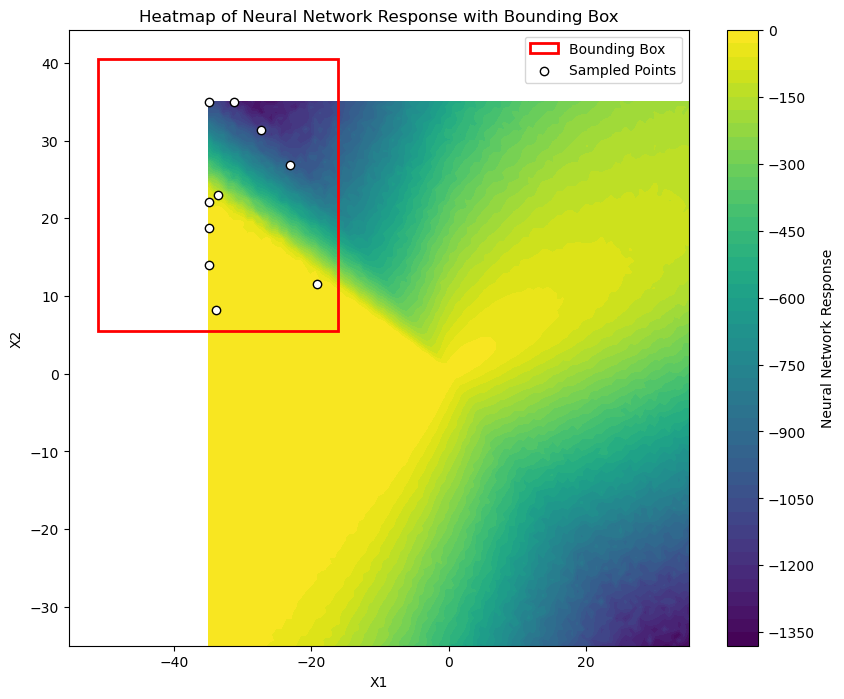

In [97]:
df_sim, df_new = perform_iteration(df_sim, df)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1657.8629
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1562.7212
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1227.8705
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 489.7447
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1881.6487
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 281.5646
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 447.6718
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 691.9271
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 874.8986
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 919.3198
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 880.9252
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 802.4753
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 602.1252
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 432.2942
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - lo

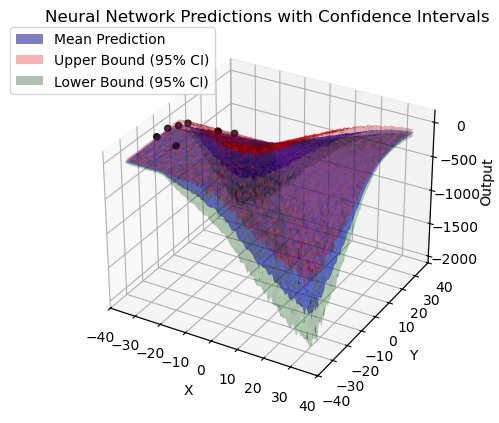

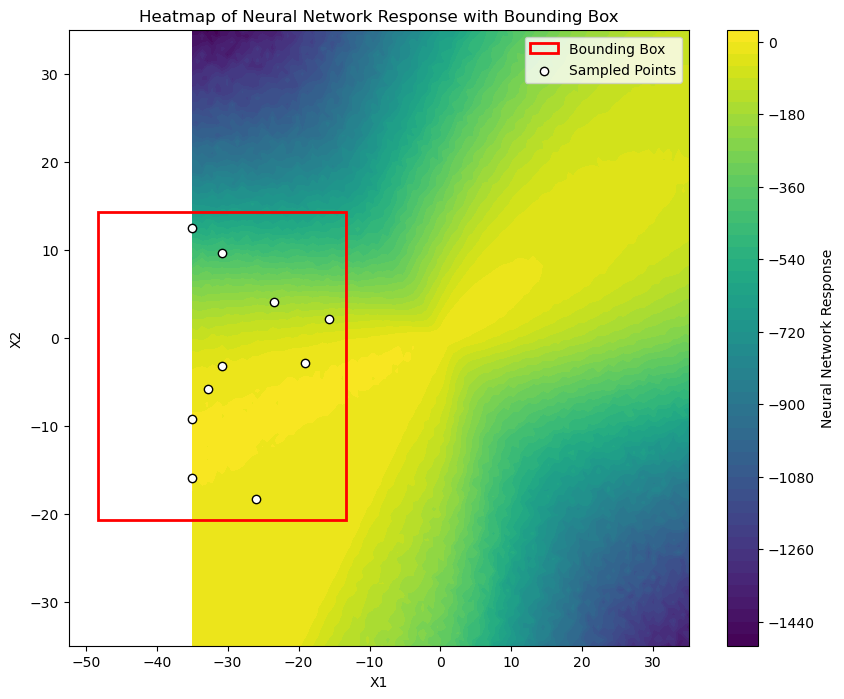

           x          y          z         a         b      sim_z      diff
4 -35.000000 -15.978239 -19.810890  7.593091 -3.055364 -16.443273 -3.367617
8 -25.934285 -18.312080 -21.153820  7.593091 -3.055364 -17.197939 -3.955881
5 -35.000000  -9.237186 -20.846170  7.593091 -3.055364 -24.007178  3.161008
7 -19.075736  -2.855471 -19.384819  7.593091 -3.055364 -24.544064  5.159245
3 -15.769465   2.161167 -19.292289  7.593091 -3.055364 -25.940589  6.648300
            x          y          z         a         b      sim_z       diff
0   -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1   15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2  -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3  -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4  -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522
..        ...        ...        ...       ...       ...        ...        ..

In [98]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

In [99]:
df_new

x          y          z         a         b      sim_z      diff
4 -35.000000 -15.978239 -19.810890  7.593091 -3.055364 -16.443273 -3.367617
8 -25.934285 -18.312080 -21.153820  7.593091 -3.055364 -17.197939 -3.955881
5 -35.000000  -9.237186 -20.846170  7.593091 -3.055364 -24.007178  3.161008
7 -19.075736  -2.855471 -19.384819  7.593091 -3.055364 -24.544064  5.159245
3 -15.769465   2.161167 -19.292289  7.593091 -3.055364 -25.940589  6.648300

In [100]:
df

x          y          z         a         b      sim_z       diff
0  -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1  15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2 -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3 -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4 -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522

In [101]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -33.37172387506455


In [102]:
df = pd.concat([df, df_new], ignore_index=True)
df

x          y          z         a         b      sim_z       diff
0  -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1  15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2 -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3 -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4 -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522
5 -35.000000 -15.978239 -19.810890  7.593091 -3.055364 -16.443273  -3.367617
6 -25.934285 -18.312080 -21.153820  7.593091 -3.055364 -17.197939  -3.955881
7 -35.000000  -9.237186 -20.846170  7.593091 -3.055364 -24.007178   3.161008
8 -19.075736  -2.855471 -19.384819  7.593091 -3.055364 -24.544064   5.159245
9 -15.769465   2.161167 -19.292289  7.593091 -3.055364 -25.940589   6.648300

In [103]:
df = df.iloc[:, :-4]
df

x          y          z
0  -5.808460 -28.536298 -21.648132
1  15.422715 -21.961785 -21.250438
2 -34.991994 -10.810749 -20.641314
3 -13.836720  -7.226277 -19.245342
4 -24.727088   2.717171 -21.194934
5 -35.000000 -15.978239 -19.810890
6 -25.934285 -18.312080 -21.153820
7 -35.000000  -9.237186 -20.846170
8 -19.075736  -2.855471 -19.384819
9 -15.769465   2.161167 -19.292289

In [104]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 6.87719677 -3.09103419]


In [105]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": -0.025, "Y":  -0.025, "Z": benchmark( -0.025,  -0.025)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y         Z
0 -0.025 -0.025 -0.133012

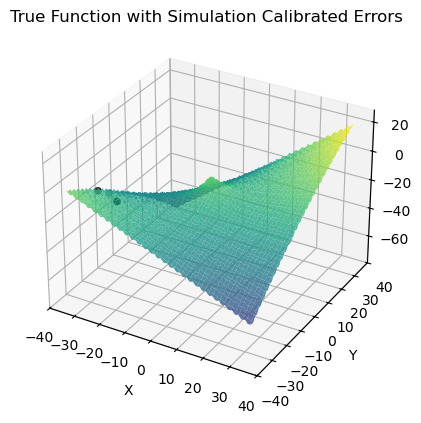

In [106]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [107]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new['z'].max()],
                          "Round_num": [1]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [108]:
df

x          y          z         a         b       sim_z        diff
0  -5.808460 -28.536298 -21.648132  6.877197 -3.091034  118.408283 -140.056416
1  15.422715 -21.961785 -21.250438  6.877197 -3.091034   44.128599  -65.379037
2 -34.991994 -10.810749 -20.641314  6.877197 -3.091034   18.253701  -38.895015
3 -13.836720  -7.226277 -19.245342  6.877197 -3.091034   -4.258636  -14.986706
4 -24.727088   2.717171 -21.194934  6.877197 -3.091034  -16.201320   -4.993614
5 -35.000000 -15.978239 -19.810890  6.877197 -3.091034   47.110273  -66.921163
6 -25.934285 -18.312080 -21.153820  6.877197 -3.091034   54.299364  -75.453183
7 -35.000000  -9.237186 -20.846170  6.877197 -3.091034   11.164134  -32.010305
8 -19.075736  -2.855471 -19.384819  6.877197 -3.091034  -11.777189   -7.607630
9 -15.769465   2.161167 -19.292289  6.877197 -3.091034  -15.731604   -3.560685

In [109]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -44.98637527599722


In [110]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

           x          y          z         a         b       sim_z        diff
0  -5.808460 -28.536298 -21.648132  6.877197 -3.091034  118.408283 -140.056416
1  15.422715 -21.961785 -21.250438  6.877197 -3.091034   44.128599  -65.379037
2 -34.991994 -10.810749 -20.641314  6.877197 -3.091034   18.253701  -38.895015
3 -13.836720  -7.226277 -19.245342  6.877197 -3.091034   -4.258636  -14.986706
4 -24.727088   2.717171 -21.194934  6.877197 -3.091034  -16.201320   -4.993614


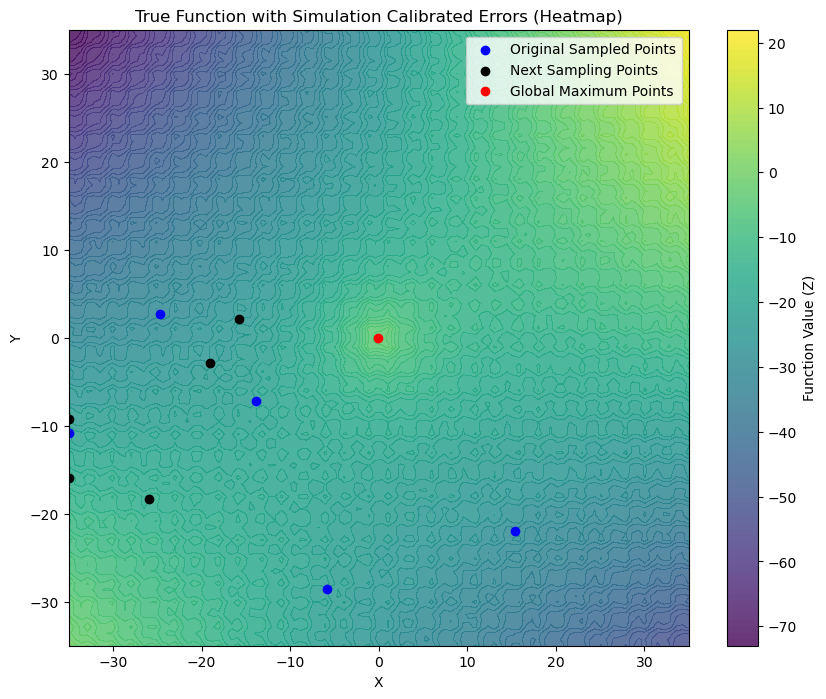

In [111]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [112]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2230.7788
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2165.3135
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1921.0352
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1253.7963
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 696.9845
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1083.9413
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 407.6299
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 372.8179
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 579.4678
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 283.6200
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 137.3473
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 362.0877
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 162.7084
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 498.7167
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - l

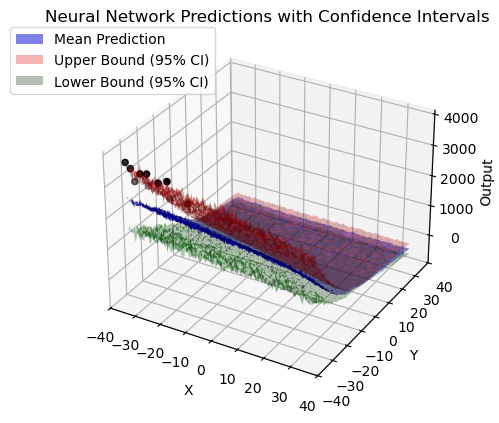

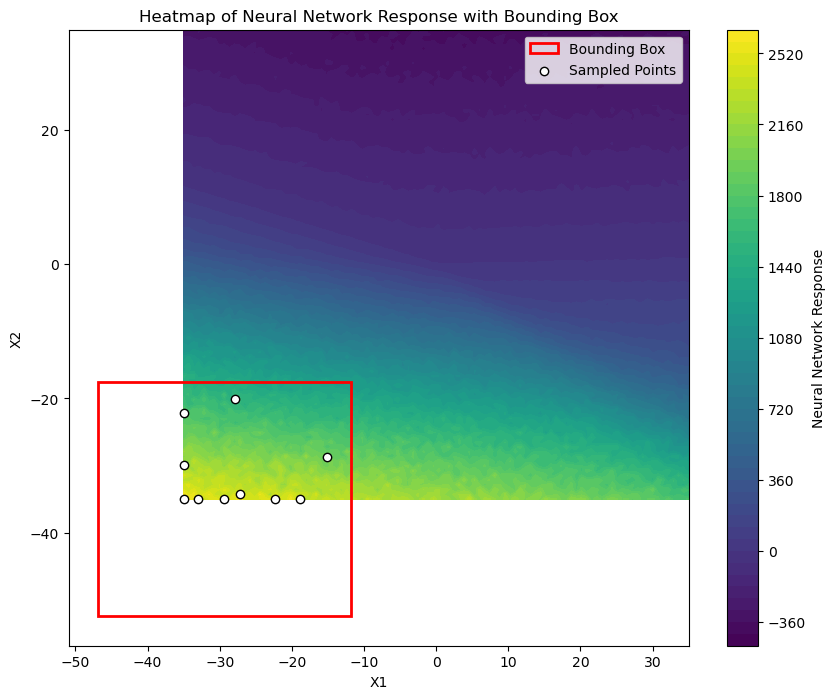

In [113]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1161.9700
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1156.1881
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1127.1840
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1045.6292
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 946.4645
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 738.6855
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 717.8805
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 691.9633
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 951.5951
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 564.4889
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 558.2592
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 351.0660
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 488.5219
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 365.8894
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

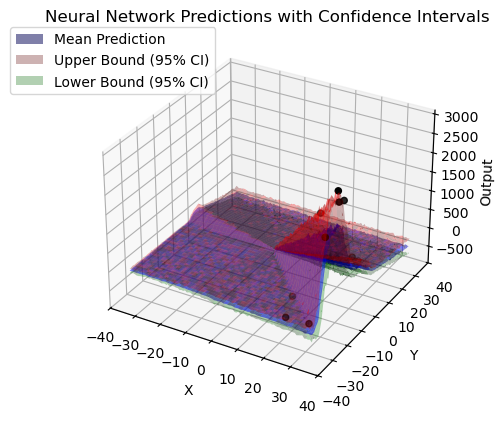

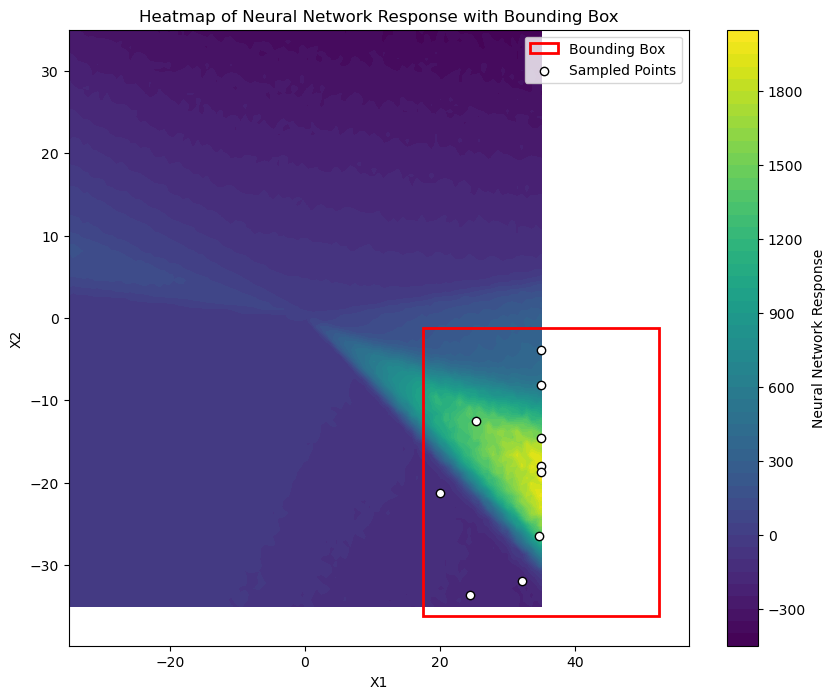

In [114]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1138.4318
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1119.3497
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1049.4867
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 944.8391
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1090.3054
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 899.0947
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 939.8680
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 943.9330
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 931.6249
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 921.9210
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 846.2574
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 819.7651
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 837.1683
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 852.9096
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - lo

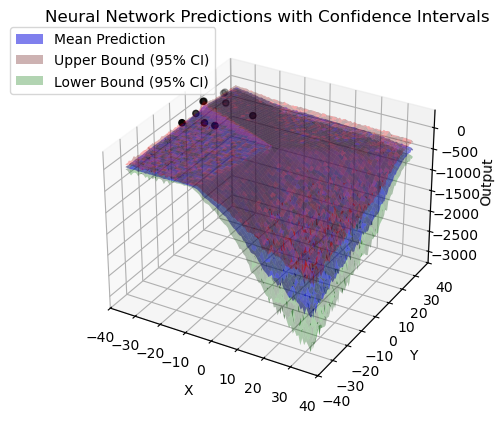

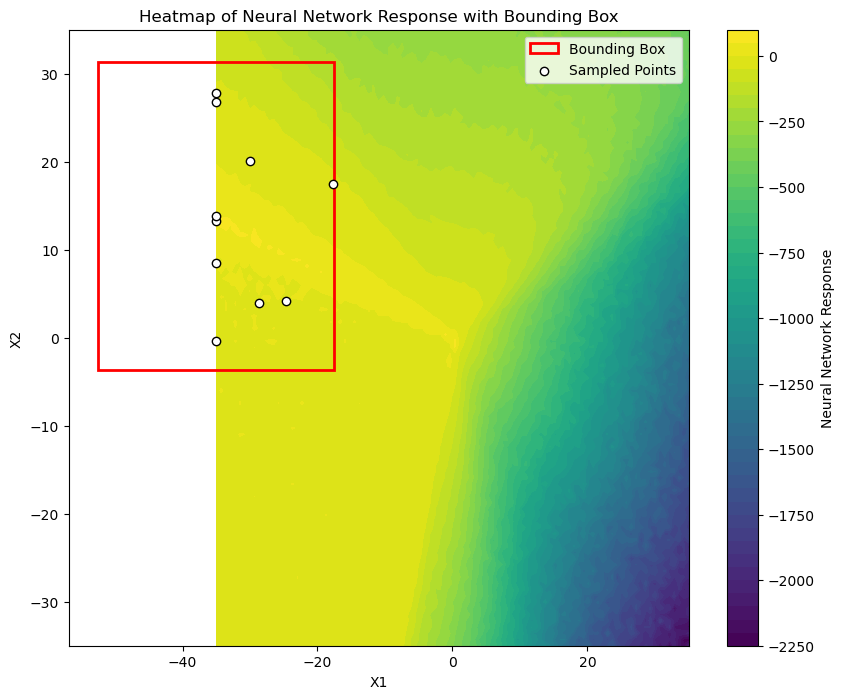

In [115]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1367.9590
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1303.1671
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1060.1592
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 963.8641
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 786.3439
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 786.6313
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 762.6328
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 756.1841
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 736.5087
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 712.5077
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 704.5527
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 717.4843
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 719.8310
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 703.6198
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - los

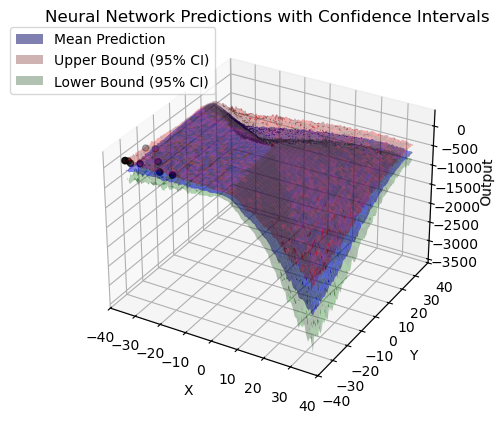

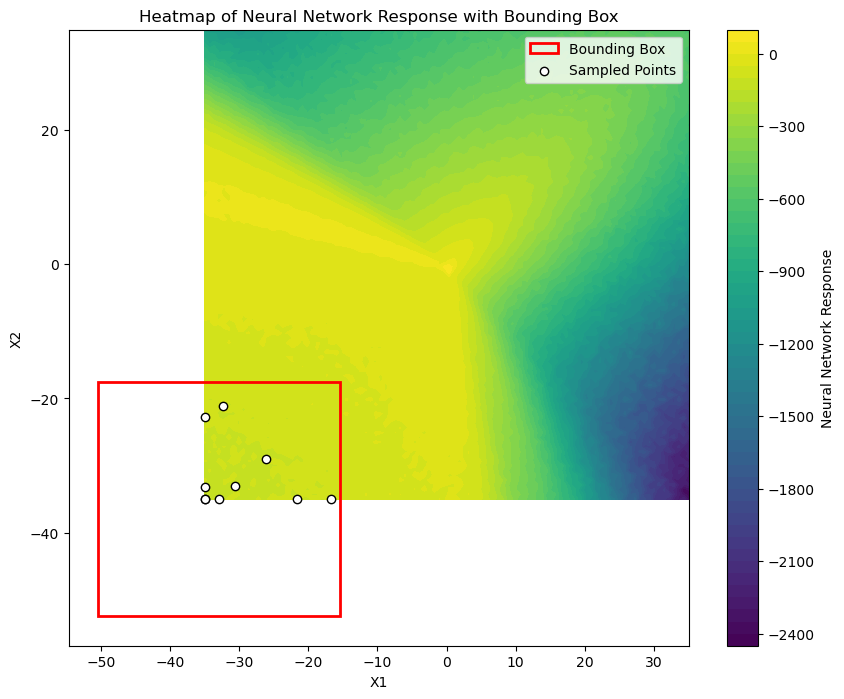

In [116]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1109.4418
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1051.0698
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 813.2629
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 918.8972
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 663.5698
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 716.6082
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 711.6876
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 628.9661
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 639.6327
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 644.3391
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 601.3826
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 603.4773
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 567.9972
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 584.5745
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss

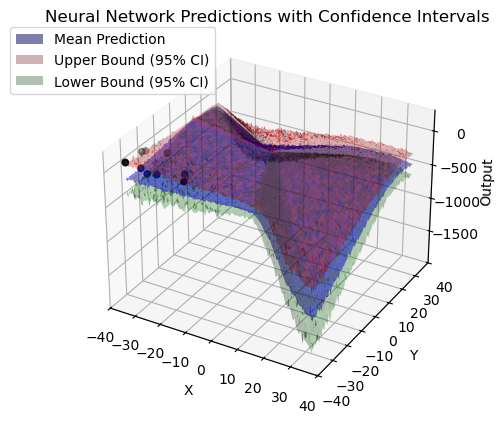

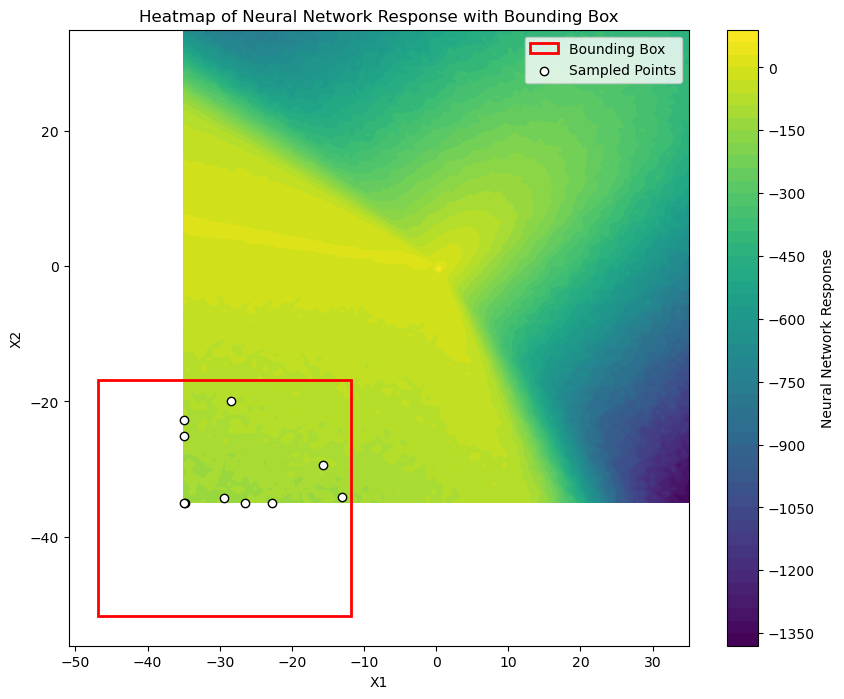

In [117]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 943.7062
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 903.0194
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 741.6002
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 704.3044
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 542.0049
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 560.5242
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 556.2112
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 545.2242
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 547.0404
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 516.8420
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 526.5348
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 526.2767
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 535.8494
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 510.2342
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 

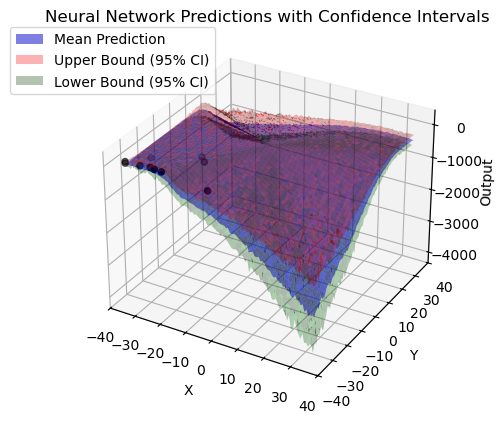

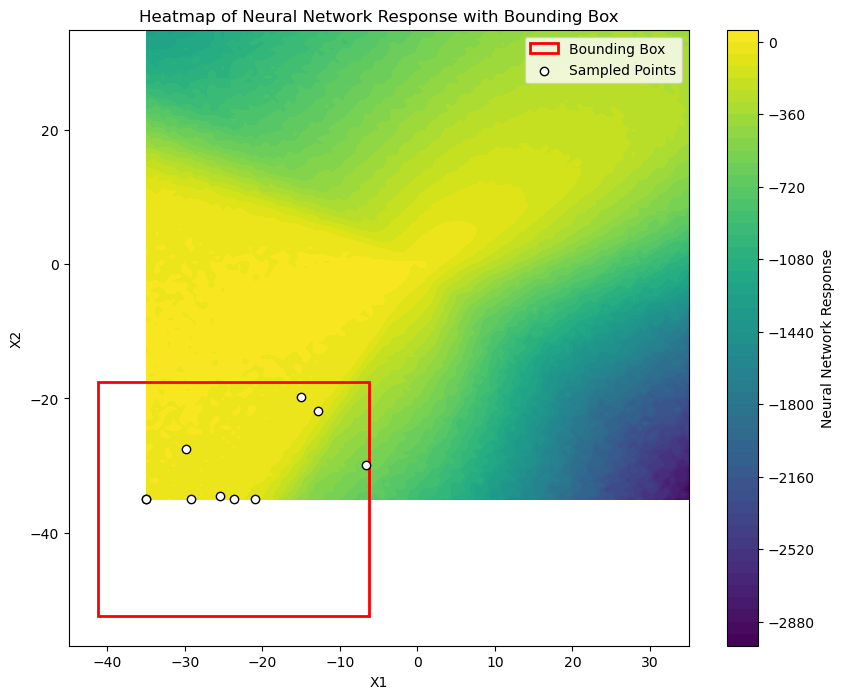

In [118]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [119]:
df_new2

x          y          z         a         b     sim_z       diff
2 -35.000000 -35.000000 -20.014281  6.877197 -3.091034  1.097631 -21.111913
7 -35.000000 -35.000000 -20.046415  6.877197 -3.091034  1.097631 -21.144046
5 -29.240973 -35.000000 -21.037593  6.877197 -3.091034 -4.301146 -16.736447
3 -25.512145 -34.608612 -22.123650  6.877197 -3.091034 -8.589032 -13.534618
9 -23.686869 -35.000000 -21.358335  6.877197 -3.091034 -8.852817 -12.505518

In [120]:
df

x          y          z         a         b       sim_z        diff
0  -5.808460 -28.536298 -21.648132  6.877197 -3.091034  118.408283 -140.056416
1  15.422715 -21.961785 -21.250438  6.877197 -3.091034   44.128599  -65.379037
2 -34.991994 -10.810749 -20.641314  6.877197 -3.091034   18.253701  -38.895015
3 -13.836720  -7.226277 -19.245342  6.877197 -3.091034   -4.258636  -14.986706
4 -24.727088   2.717171 -21.194934  6.877197 -3.091034  -16.201320   -4.993614
5 -35.000000 -15.978239 -19.810890  6.877197 -3.091034   47.110273  -66.921163
6 -25.934285 -18.312080 -21.153820  6.877197 -3.091034   54.299364  -75.453183
7 -35.000000  -9.237186 -20.846170  6.877197 -3.091034   11.164134  -32.010305
8 -19.075736  -2.855471 -19.384819  6.877197 -3.091034  -11.777189   -7.607630
9 -15.769465   2.161167 -19.292289  6.877197 -3.091034  -15.731604   -3.560685

In [121]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x          y          z         a         b       sim_z  \
0   -5.808460 -28.536298 -21.648132  6.877197 -3.091034  118.408283   
1   15.422715 -21.961785 -21.250438  6.877197 -3.091034   44.128599   
2  -34.991994 -10.810749 -20.641314  6.877197 -3.091034   18.253701   
3  -13.836720  -7.226277 -19.245342  6.877197 -3.091034   -4.258636   
4  -24.727088   2.717171 -21.194934  6.877197 -3.091034  -16.201320   
5  -35.000000 -15.978239 -19.810890  6.877197 -3.091034   47.110273   
6  -25.934285 -18.312080 -21.153820  6.877197 -3.091034   54.299364   
7  -35.000000  -9.237186 -20.846170  6.877197 -3.091034   11.164134   
8  -19.075736  -2.855471 -19.384819  6.877197 -3.091034  -11.777189   
9  -15.769465   2.161167 -19.292289  6.877197 -3.091034  -15.731604   
10 -35.000000 -35.000000 -20.014281  6.877197 -3.091034    1.097631   
11 -35.000000 -35.000000 -20.046415  6.877197 -3.091034    1.097631   
12 -29.240973 -35.000000 -21.037593  6.877197 -3.091034   -4.301146   
13 -25.512145 -34.608612 -22.123650  6.877197 -3.091034   -8.589032   
14 -23.686869 -35.000000 -21.358335  6.877197 -3.091034   -8.852817   

          diff  
0  -140.056416  
1   -65.379037  
2   -38.895015  
3   -14.986706  
4    -4.993614  
5   -66.921163  
6   -75.453183  
7   -32.010305  
8    -7.607630  
9    -3.560685  
10  -21.111913  
11  -21.144046  
12  -16.736447  
13  -13.534618  
14  -12.505518

In [122]:
df = df.iloc[:, :-4]
df

x          y          z
0   -5.808460 -28.536298 -21.648132
1   15.422715 -21.961785 -21.250438
2  -34.991994 -10.810749 -20.641314
3  -13.836720  -7.226277 -19.245342
4  -24.727088   2.717171 -21.194934
5  -35.000000 -15.978239 -19.810890
6  -25.934285 -18.312080 -21.153820
7  -35.000000  -9.237186 -20.846170
8  -19.075736  -2.855471 -19.384819
9  -15.769465   2.161167 -19.292289
10 -35.000000 -35.000000 -20.014281
11 -35.000000 -35.000000 -20.046415
12 -29.240973 -35.000000 -21.037593
13 -25.512145 -34.608612 -22.123650
14 -23.686869 -35.000000 -21.358335

In [123]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new2['z'].max()],
                          "Round_num": [2]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [124]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 9.10084439 -3.19990211]


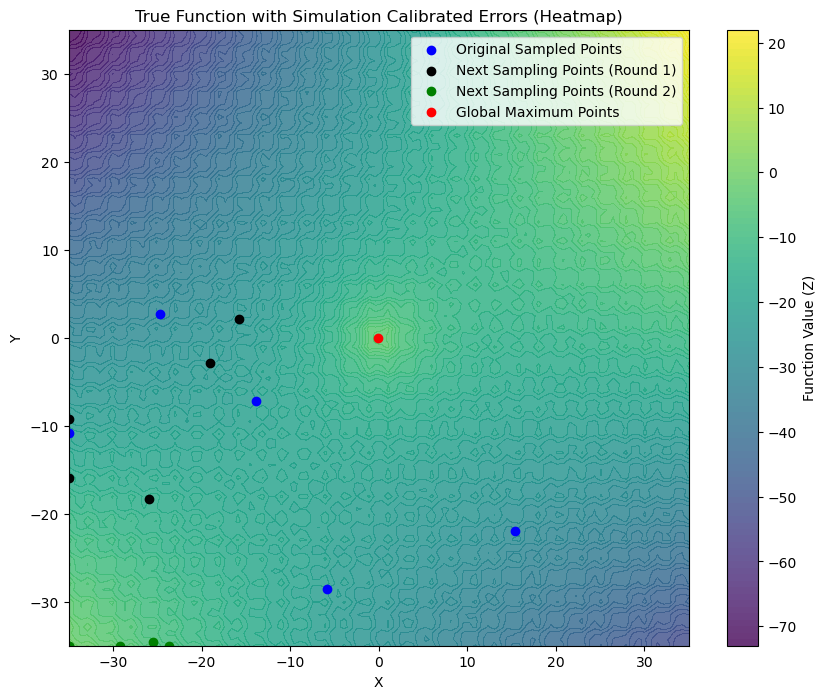

In [125]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [126]:
df_original

x          y          z         a         b       sim_z        diff
0  -5.808460 -28.536298 -21.648132  6.877197 -3.091034  118.408283 -140.056416
1  15.422715 -21.961785 -21.250438  6.877197 -3.091034   44.128599  -65.379037
2 -34.991994 -10.810749 -20.641314  6.877197 -3.091034   18.253701  -38.895015
3 -13.836720  -7.226277 -19.245342  6.877197 -3.091034   -4.258636  -14.986706
4 -24.727088   2.717171 -21.194934  6.877197 -3.091034  -16.201320   -4.993614

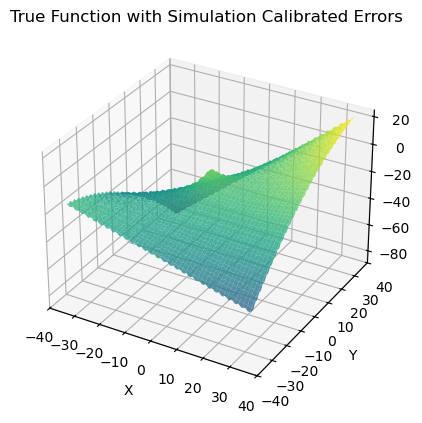

In [127]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [128]:
round_val_df

Highest_phy_Response Round_num
0            -19.245342         0
1            -19.292289         1
2            -20.014281         2

In [129]:
df_new3 = pd.DataFrame

df_sim = df.copy()

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5236.0054
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5161.4604
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4877.9116
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3995.6562
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2033.1790
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1071.1193
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 571.7054
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 185.6949
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 589.0399
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 304.5811
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 638.3666
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 232.1533
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 207.8353
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 250.3179
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - 

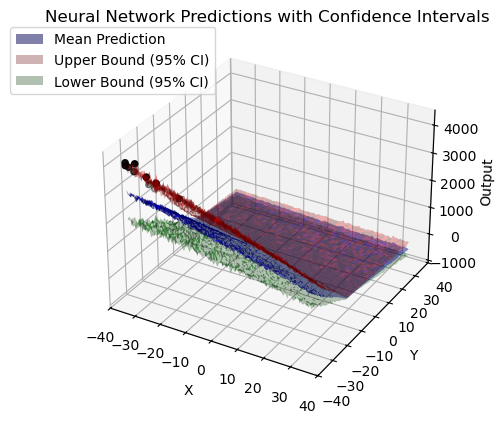

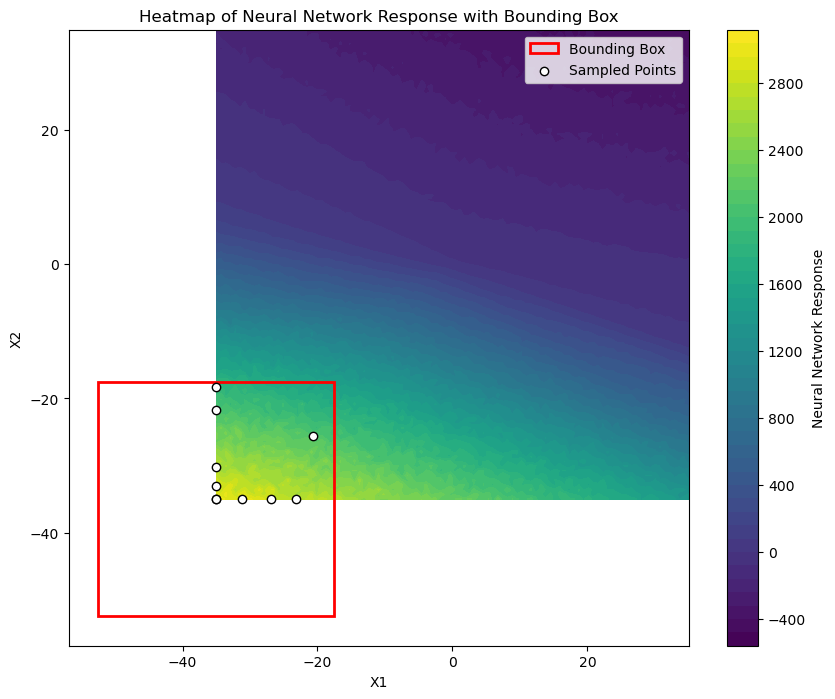

In [130]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3271.9587
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3229.3977
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3114.4475
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2778.0327
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2514.1086
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2849.3943
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2317.2947
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2338.6582
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2475.2178
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2574.8313
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2425.3608
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2465.1802
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2299.6702
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2487.7144
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

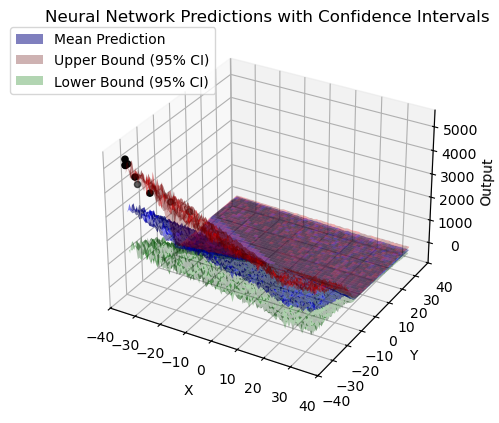

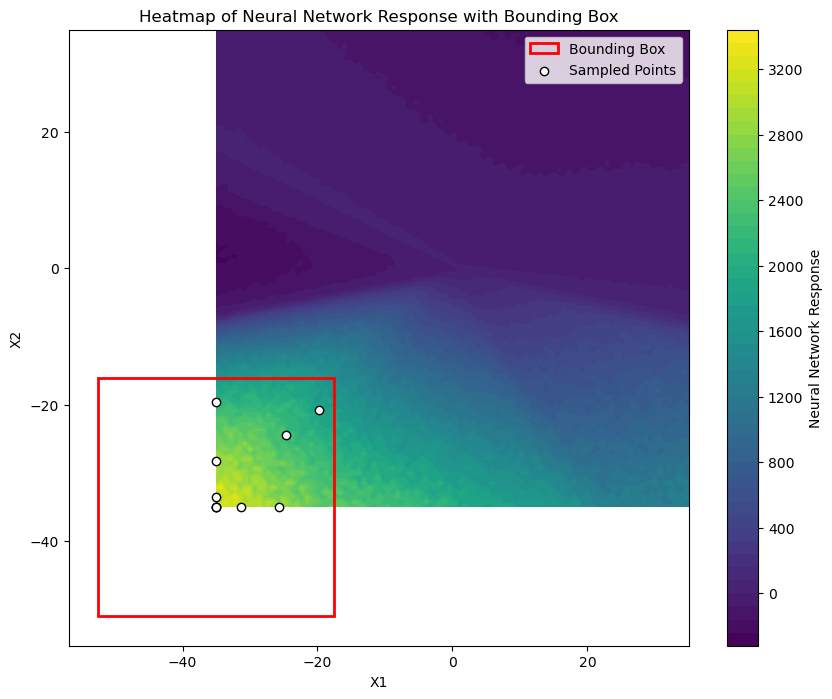

In [131]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2434.4929
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2422.4983
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2383.8936
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2280.6638
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2185.8728
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2138.4128
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2203.9592
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2132.3025
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1876.9784
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1902.6078
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2214.9248
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2148.5159
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1900.0210
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2081.6860
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

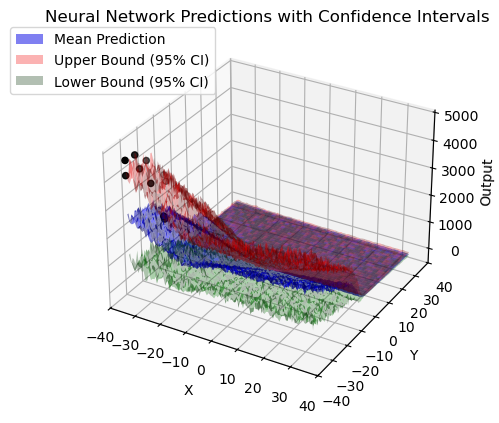

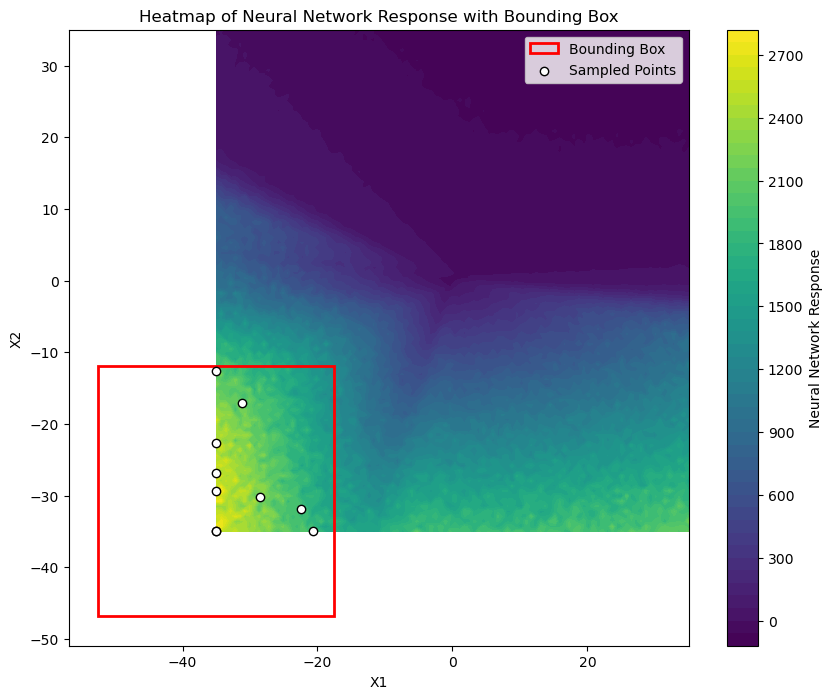

In [132]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1984.4910
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1979.2014
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1956.7092
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1917.9962
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1899.0040
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1833.0657
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1858.3683
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1741.4812
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1743.1658
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1760.7166
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1817.9797
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1933.7411
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1849.0963
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1857.1050
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms

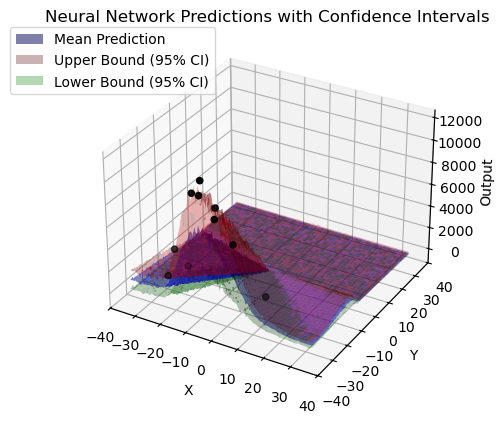

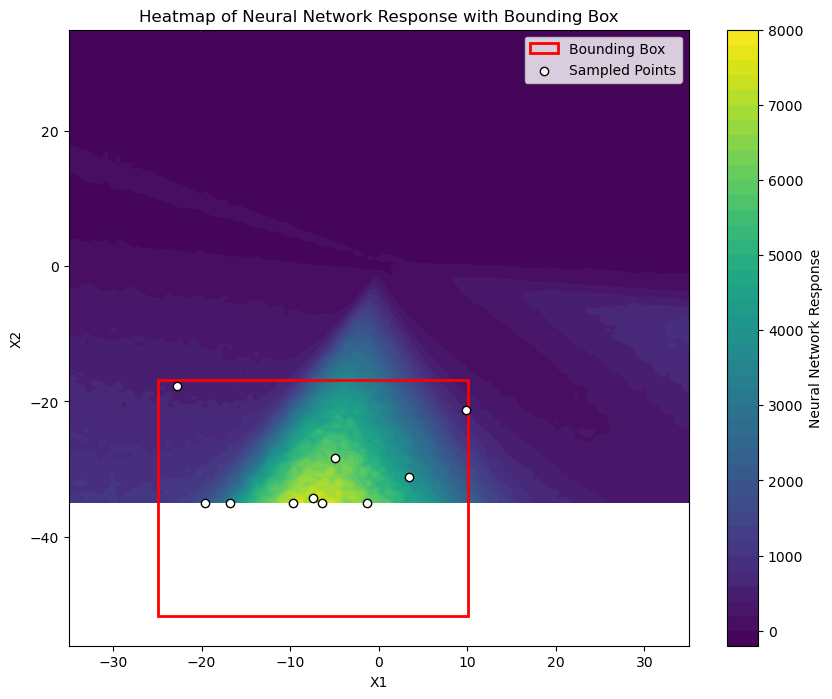

In [133]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1769.4613
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1761.5553
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1738.5704
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1719.5901
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1704.0950
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1677.8547
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1674.8062
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1650.8503
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1655.3914
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1597.6860
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1621.1404
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1532.8158
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1474.1259
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1459.2854
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

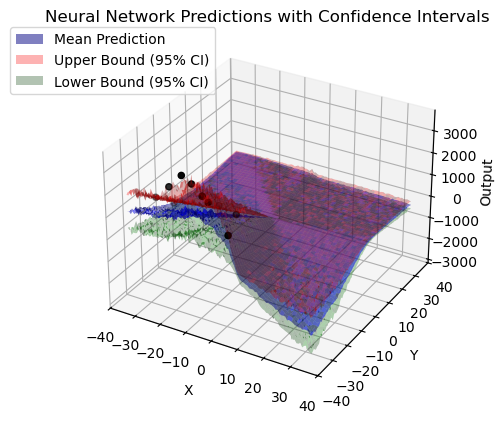

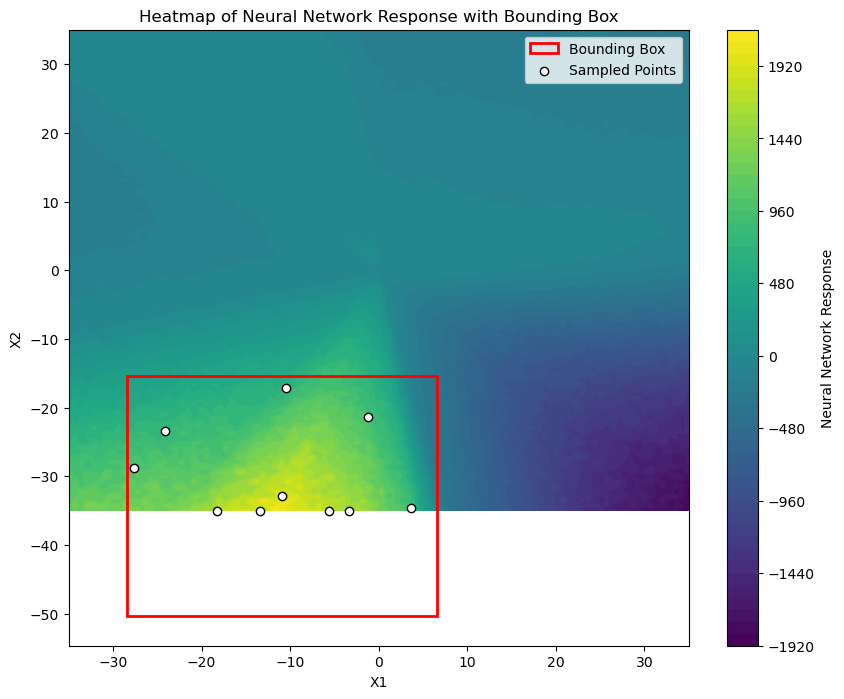

In [134]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1612.7009
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1605.6378
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1581.4878
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1534.4913
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1500.7500
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1456.4169
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1440.0236
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1419.6129
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1469.4319
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1431.6776
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1361.6301
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1354.9525
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1354.7599
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1280.0031
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms

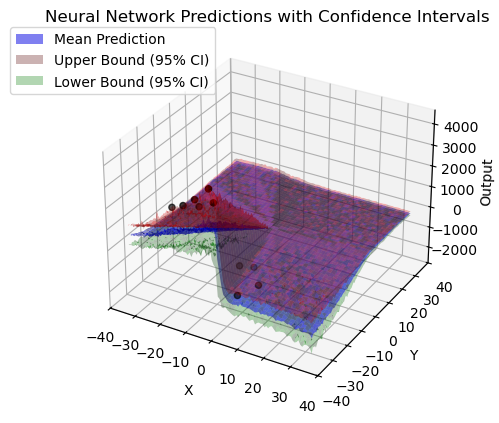

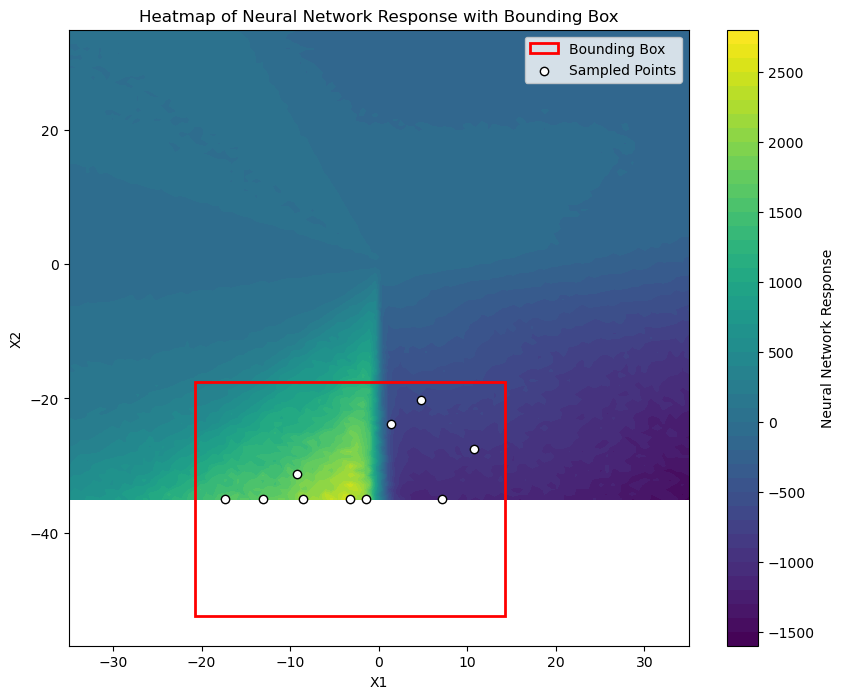

In [135]:
df_sim, df_new3 = perform_iteration(df_sim, df)

In [136]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new3['z'].max()],
                          "Round_num": [3]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [137]:
df = pd.concat([df, df_new3], ignore_index=True)

In [138]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 7.8700317  -3.21653696]


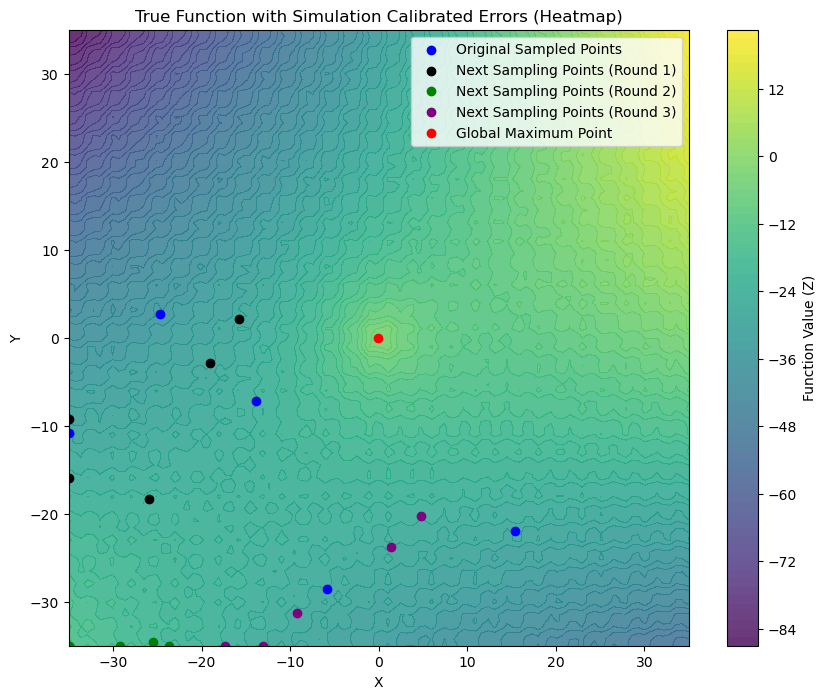

In [139]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')
ax.scatter(df_new3["x"], df_new3["y"], color='purple', marker='o', label='Next Sampling Points (Round 3)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

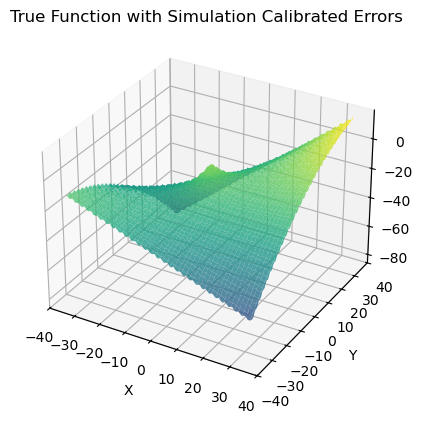

In [140]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [141]:
round_val_df

Highest_phy_Response Round_num
0            -19.245342         0
1            -19.292289         1
2            -20.014281         2
3            -19.954514         3

In [142]:
round_val_df.to_excel("NN_round2.xlsx", index=False) 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Read the Excel file
file_path = "NN_round2.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

C:\Users\Simon\AppData\Local\Temp\ipykernel_26580\1869974771.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


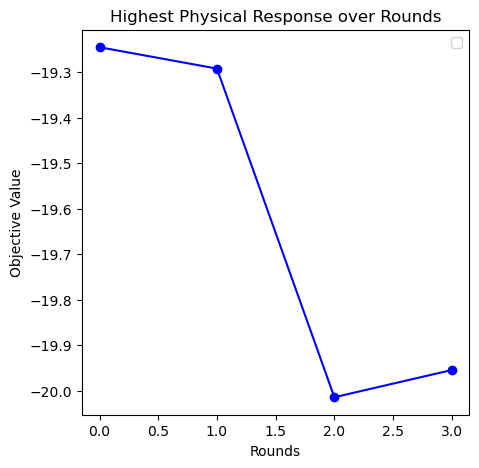

In [4]:
# Plotting
plt.figure(figsize=(5, 5))
plt.plot(df['Round_num'], df['Highest_phy_Response'], marker='o', linestyle='-', color='b')

# Labels and Title
plt.xlabel('Rounds')
plt.ylabel('Objective Value')
plt.title('Highest Physical Response over Rounds')
plt.legend()

# Show plot
plt.show()